In [ ]:
#!pip install tensorflow

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import time
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import normalize
from scipy.linalg import eigh_tridiagonal
import scipy

#Creamos una semilla que asegurará que las variables pseudoaleatorias sean constantes entre intentos
seed = 128
np.random.seed(seed)
tf.random.set_seed(seed)
tf.keras.utils.set_random_seed(seed)

# Probando No-Linealidades


## Fracción


In [ ]:
num_domain = 30
minval = 0
maxval = 2
x = np.linspace(minval, maxval, num_domain)

gamma = 1

In [ ]:
n_inputs = 1
n_outputs = 1
activation = 'tanh'

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((n_inputs,)))
model.add(tf.keras.layers.Dense(units=4, activation=activation))
model.add(tf.keras.layers.Dense(units=7, activation=activation))
model.add(tf.keras.layers.Dense(units=n_outputs))

model.summary()

early_stop = EarlyStopping(
    monitor='loss',
    patience=8,
    restore_best_weights=True
)

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 7)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 51 (204.00 B)

 Trainable params: 51 (204.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 1200
learning_rate = 0.01

model.compile(optimizer="adam", loss="mse")

y_frac = 1/(x+2)

print(len(x), len(y_frac))

history = model.fit(x, y_frac, epochs=epochs, batch_size=1, callbacks=[early_stop], verbose=0)
final_epoch = len(history.history['loss'])
final_train_error = history.history['loss'][-1]
print(final_epoch, final_train_error)

30 30
124 2.3881000743131153e-05


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


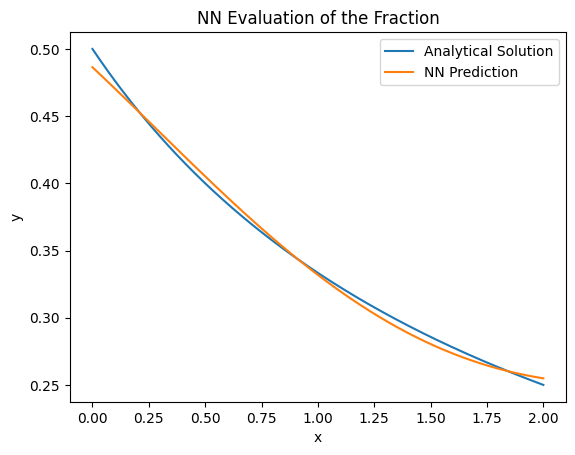

In [ ]:
x_test = np.linspace(0, 2, 300)
y_pred = model.predict(x_test)

y_true = 1/(x_test+2)

plt.plot(x_test, y_true)
plt.plot(x_test, y_pred)
plt.title('NN Evaluation of the Fraction')
plt.legend(['Analytical Solution', 'NN Prediction'])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

In [ ]:
val_error = 0
for i in range(len(y_pred)):

  val_error += (y_pred[i] - y_true[i])**2

test_error = val_error/len(y_pred)
test_error

array([1.82731681e-05])

### Montecarlo

In [ ]:
num_domain = 30
minval = 0
maxval = 2
x = np.linspace(minval, maxval, num_domain)

gamma = 1

epochs = 1200
learning_rate = 0.01

n_montecarlo = 24

final_epoch_arr = np.zeros(n_montecarlo)
final_train_error_arr = np.zeros(n_montecarlo)
test_error_arr = np.zeros(n_montecarlo)

def nn_frac(j, epochs, learning_rate, x):

  n_inputs = 1
  n_outputs = 1
  activation = 'tanh'

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input((n_inputs,)))
  model.add(tf.keras.layers.Dense(units=4, activation=activation))
  model.add(tf.keras.layers.Dense(units=7, activation=activation))
  model.add(tf.keras.layers.Dense(units=n_outputs))

  if j == 0:

    model.summary()

  early_stop = EarlyStopping(
      monitor='loss',
      patience=8,
      restore_best_weights=True
  )

  model.compile(optimizer="adam", loss="mse")

  y_frac = 1/(x+2)

  history = model.fit(x, y_frac, epochs=epochs, batch_size=1, callbacks=[early_stop], verbose=0)
  final_epoch = len(history.history['loss'])
  final_train_error = history.history['loss'][-1]

  x_test = np.linspace(0, 2, 300)
  y_pred = model.predict(x_test)

  y_true = 1/(x_test+2)

  val_error = 0
  for i in range(len(y_pred)):

    val_error += (y_pred[i] - y_true[i])**2

  test_error = val_error/len(y_pred)
  test_error = test_error[0]

  final_epoch_arr[j] = final_epoch
  final_train_error_arr[j] = final_train_error
  test_error_arr[j] = test_error

for j in range(n_montecarlo):

  nn_frac(j, epochs, learning_rate, x)

final_epoch_mean = final_epoch_arr.mean()
final_epoch_var = final_epoch_arr.var()
final_train_error_mean = final_train_error_arr.mean()
final_train_error_var = final_train_error_arr.var()
test_error_mean = test_error_arr.mean()
test_error_var = test_error_arr.var()

print(f"""
Mean final epoch: {final_epoch_mean}                Final Epoch Variance: {final_epoch_var}
Mean final error: {final_train_error_mean}             Final error Variance: {final_train_error_var}
Mean testing error: {test_error_mean}         Testing error Variance: {test_error_var}
""")

## Péndulo

In [ ]:
num_domain = 64
minval = 0
maxval = 2.5

x = np.linspace(0, 2.5, 64)

gamma = 1
g = 9.8
L = 1
w = np.sqrt(g/L)
T = 2*np.pi/w

In [ ]:
n_inputs = 1
n_outputs = 1
activation = 'tanh'

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((n_inputs,)))
model.add(tf.keras.layers.Dense(units=4, activation=activation))
model.add(tf.keras.layers.Dense(units=4, activation=activation))
model.add(tf.keras.layers.Dense(units=7, activation=activation))
model.add(tf.keras.layers.Dense(units=n_outputs))

model.summary()

early_stop = EarlyStopping(
    monitor='loss',
    patience=15,
    restore_best_weights=True
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
epochs = 2000
learning_rate = 0.01

model.compile(optimizer="adam", loss="mse", metrics=["mse"])

theta0 = np.pi / 4  # Initial angle (rad)
omega0 = 0.0        # Initial angular velocity (rad/s)
t_0 = 0           # Start time (s)
t_f = 2.5           # End time (s)
dt = (t_f-t_0)/63           # Time step (s)

# Number of steps
n = int((t_f - t_0) / dt)

# Arrays to store results
t = np.linspace(t_0, t_f, n+1)
y_kutta = np.zeros(n+1)
omega = np.zeros(n+1)

# Initial conditions
y_kutta[0] = theta0
omega[0] = omega0

# Define the system of ODEs
def f_theta(y_kutta, omega):
    return omega

def f_omega(y_kutta, omega):
    return - (g / L) * np.sin(y_kutta)

# Runge-Kutta 4th Order Method
for i in range(n):
    k1_theta = dt * f_theta(y_kutta[i], omega[i])
    k1_omega = dt * f_omega(y_kutta[i], omega[i])

    k2_theta = dt * f_theta(y_kutta[i] + 0.5 * k1_theta, omega[i] + 0.5 * k1_omega)
    k2_omega = dt * f_omega(y_kutta[i] + 0.5 * k1_theta, omega[i] + 0.5 * k1_omega)

    k3_theta = dt * f_theta(y_kutta[i] + 0.5 * k2_theta, omega[i] + 0.5 * k2_omega)
    k3_omega = dt * f_omega(y_kutta[i] + 0.5 * k2_theta, omega[i] + 0.5 * k2_omega)

    k4_theta = dt * f_theta(y_kutta[i] + k3_theta, omega[i] + k3_omega)
    k4_omega = dt * f_omega(y_kutta[i] + k3_theta, omega[i] + k3_omega)

    y_kutta[i+1] = y_kutta[i] + (k1_theta + 2*k2_theta + 2*k3_theta + k4_theta) / 6
    omega[i+1] = omega[i] + (k1_omega + 2*k2_omega + 2*k3_omega + k4_omega) / 6

print(len(x), len(y_kutta))

history = model.fit(x, y_kutta, epochs=epochs, batch_size=1, callbacks=[early_stop], verbose=0)
final_epoch = len(history.history['loss'])
final_train_error = history.history['loss'][-1]
print(final_epoch, final_train_error)

64 64
2000 0.0003296021022833884


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


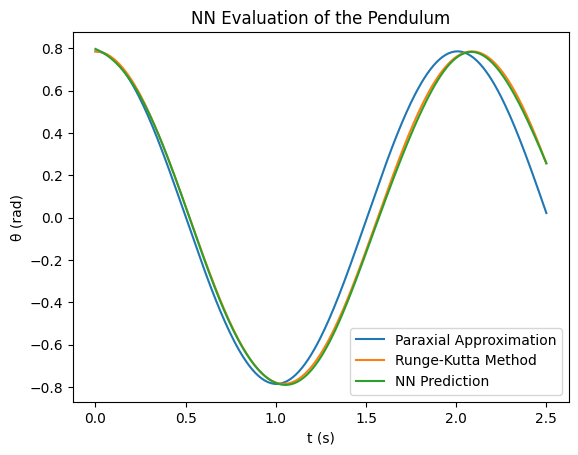

In [ ]:
x_test = np.linspace(0, 2.5, 300)
y_pred = model.predict(x_test)

theta0 = np.pi / 4  # Initial angle (rad)
omega0 = 0.0        # Initial angular velocity (rad/s)
t_0 = 0           # Start time (s)
t_f = 2.5           # End time (s)
dt = (t_f-t_0)/299           # Time step (s)

# Number of steps
n = int((t_f - t_0) / dt)

# Arrays to store results
t = np.linspace(t_0, t_f, n+1)
y_kutta = np.zeros(n+1)
omega = np.zeros(n+1)

# Initial conditions
y_kutta[0] = theta0
omega[0] = omega0

# Define the system of ODEs
def f_theta(y_kutta, omega):
    return omega

def f_omega(y_kutta, omega):
    return - (g / L) * np.sin(y_kutta)

# Runge-Kutta 4th Order Method
for i in range(n):
    k1_theta = dt * f_theta(y_kutta[i], omega[i])
    k1_omega = dt * f_omega(y_kutta[i], omega[i])

    k2_theta = dt * f_theta(y_kutta[i] + 0.5 * k1_theta, omega[i] + 0.5 * k1_omega)
    k2_omega = dt * f_omega(y_kutta[i] + 0.5 * k1_theta, omega[i] + 0.5 * k1_omega)

    k3_theta = dt * f_theta(y_kutta[i] + 0.5 * k2_theta, omega[i] + 0.5 * k2_omega)
    k3_omega = dt * f_omega(y_kutta[i] + 0.5 * k2_theta, omega[i] + 0.5 * k2_omega)

    k4_theta = dt * f_theta(y_kutta[i] + k3_theta, omega[i] + k3_omega)
    k4_omega = dt * f_omega(y_kutta[i] + k3_theta, omega[i] + k3_omega)

    y_kutta[i+1] = y_kutta[i] + (k1_theta + 2*k2_theta + 2*k3_theta + k4_theta) / 6
    omega[i+1] = omega[i] + (k1_omega + 2*k2_omega + 2*k3_omega + k4_omega) / 6

y_para = np.pi/4 * np.sin(w*x_test + np.pi/2)

plt.plot(x_test, y_para)
plt.plot(x_test, y_kutta)
plt.plot(x_test, y_pred)
plt.title('NN Evaluation of the Pendulum')
plt.legend(['Paraxial Approximation', 'Runge-Kutta Method', 'NN Prediction'])
plt.xlabel("t (s)")
plt.ylabel("θ (rad)")
plt.show()

In [ ]:
val_error = 0
for i in range(len(y_pred)):

  val_error += (y_pred[i] - y_kutta[i])**2

test_error = val_error/len(y_pred)
test_error

array([0.00013481])

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


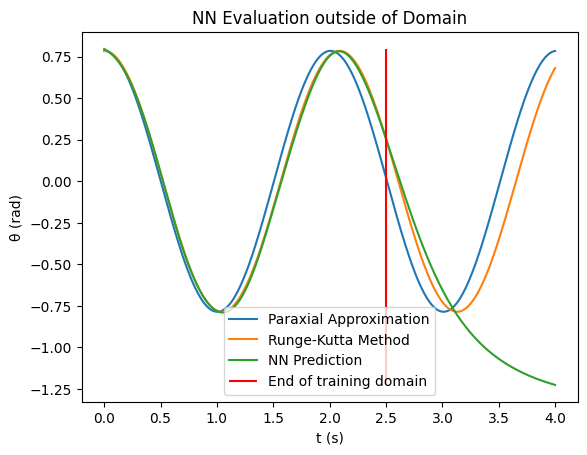

In [ ]:
x_test = np.linspace(0, 4, 300)
y_pred = model.predict(x_test)

theta0 = np.pi / 4  # Initial angle (rad)
omega0 = 0.0        # Initial angular velocity (rad/s)
t_0 = 0           # Start time (s)
t_f = 4           # End time (s)
dt = (t_f-t_0)/299           # Time step (s)

# Number of steps
n = int((t_f - t_0) / dt)

# Arrays to store results
t = np.linspace(t_0, t_f, n+1)
y_kutta = np.zeros(n+1)
omega = np.zeros(n+1)

# Initial conditions
y_kutta[0] = theta0
omega[0] = omega0

# Define the system of ODEs
def f_theta(y_kutta, omega):
    return omega

def f_omega(y_kutta, omega):
    return - (g / L) * np.sin(y_kutta)

# Runge-Kutta 4th Order Method
for i in range(n):
    k1_theta = dt * f_theta(y_kutta[i], omega[i])
    k1_omega = dt * f_omega(y_kutta[i], omega[i])

    k2_theta = dt * f_theta(y_kutta[i] + 0.5 * k1_theta, omega[i] + 0.5 * k1_omega)
    k2_omega = dt * f_omega(y_kutta[i] + 0.5 * k1_theta, omega[i] + 0.5 * k1_omega)

    k3_theta = dt * f_theta(y_kutta[i] + 0.5 * k2_theta, omega[i] + 0.5 * k2_omega)
    k3_omega = dt * f_omega(y_kutta[i] + 0.5 * k2_theta, omega[i] + 0.5 * k2_omega)

    k4_theta = dt * f_theta(y_kutta[i] + k3_theta, omega[i] + k3_omega)
    k4_omega = dt * f_omega(y_kutta[i] + k3_theta, omega[i] + k3_omega)

    y_kutta[i+1] = y_kutta[i] + (k1_theta + 2*k2_theta + 2*k3_theta + k4_theta) / 6
    omega[i+1] = omega[i] + (k1_omega + 2*k2_omega + 2*k3_omega + k4_omega) / 6

y_para = np.pi/4 * np.sin(w*x_test + np.pi/2)

plt.plot(x_test, y_para)
plt.plot(x_test, y_kutta)
plt.plot(x_test, y_pred)
plt.vlines(2.5, min(min(y_para), min(y_pred)), max(max(y_para), max(y_pred)), colors="r")
plt.title('NN Evaluation outside of Domain')
plt.legend(['Paraxial Approximation', 'Runge-Kutta Method', 'NN Prediction', 'End of training domain'])
plt.xlabel("t (s)")
plt.ylabel("θ (rad)")
plt.show()

### Montecarlo

In [ ]:
num_domain = 64
minval = 0
maxval = 2.5
x = np.linspace(minval, maxval, num_domain)

gamma = 1

g = 9.8
L = 1
w = np.sqrt(g/L)
T = 2*np.pi/w

epochs = 2000
learning_rate = 0.02

n_montecarlo = 24

final_epoch_arr = np.zeros(n_montecarlo)
final_train_error_arr = np.zeros(n_montecarlo)
test_error_arr = np.zeros(n_montecarlo)

def nn_pend(j, epochs, learning_rate, x):

  n_inputs = 1
  n_outputs = 1
  activation = 'tanh'

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input((n_inputs,)))
  model.add(tf.keras.layers.Dense(units=4, activation=activation))
  model.add(tf.keras.layers.Dense(units=4, activation=activation))
  model.add(tf.keras.layers.Dense(units=7, activation=activation))
  model.add(tf.keras.layers.Dense(units=n_outputs))

  if j == 0:

    model.summary()

  early_stop = EarlyStopping(
      monitor='loss',
      patience=8,
      restore_best_weights=True
  )

  model.compile(optimizer="adam", loss="mse")

  theta0 = np.pi / 4  # Initial angle (rad)
  omega0 = 0.0        # Initial angular velocity (rad/s)
  t_0 = 0           # Start time (s)
  t_f = 2.5           # End time (s)
  dt = (t_f-t_0)/63           # Time step (s)

  # Number of steps
  n = int((t_f - t_0) / dt)

  # Arrays to store results
  t = np.linspace(t_0, t_f, n+1)
  y_kutta = np.zeros(n+1)
  omega = np.zeros(n+1)

  # Initial conditions
  y_kutta[0] = theta0
  omega[0] = omega0

  # Define the system of ODEs
  def f_theta(y_kutta, omega):
      return omega

  def f_omega(y_kutta, omega):
      return - (g / L) * np.sin(y_kutta)

  # Runge-Kutta 4th Order Method
  for i in range(n):
      k1_theta = dt * f_theta(y_kutta[i], omega[i])
      k1_omega = dt * f_omega(y_kutta[i], omega[i])

      k2_theta = dt * f_theta(y_kutta[i] + 0.5 * k1_theta, omega[i] + 0.5 * k1_omega)
      k2_omega = dt * f_omega(y_kutta[i] + 0.5 * k1_theta, omega[i] + 0.5 * k1_omega)

      k3_theta = dt * f_theta(y_kutta[i] + 0.5 * k2_theta, omega[i] + 0.5 * k2_omega)
      k3_omega = dt * f_omega(y_kutta[i] + 0.5 * k2_theta, omega[i] + 0.5 * k2_omega)

      k4_theta = dt * f_theta(y_kutta[i] + k3_theta, omega[i] + k3_omega)
      k4_omega = dt * f_omega(y_kutta[i] + k3_theta, omega[i] + k3_omega)

      y_kutta[i+1] = y_kutta[i] + (k1_theta + 2*k2_theta + 2*k3_theta + k4_theta) / 6
      omega[i+1] = omega[i] + (k1_omega + 2*k2_omega + 2*k3_omega + k4_omega) / 6

  history = model.fit(x, y_kutta, epochs=epochs, batch_size=1, callbacks=[early_stop], verbose=0)
  final_epoch = len(history.history['loss'])
  final_train_error = history.history['loss'][-1]

  x_test = np.linspace(0, 2.5, 300)
  y_pred = model.predict(x_test)

  theta0 = np.pi / 4  # Initial angle (rad)
  omega0 = 0.0        # Initial angular velocity (rad/s)
  t_0 = 0           # Start time (s)
  t_f = 2.5           # End time (s)
  dt = (t_f-t_0)/299           # Time step (s)

  # Number of steps
  n = int((t_f - t_0) / dt)

  # Arrays to store results
  t = np.linspace(t_0, t_f, n+1)
  y_kutta = np.zeros(n+1)
  omega = np.zeros(n+1)

  # Initial conditions
  y_kutta[0] = theta0
  omega[0] = omega0

  # Define the system of ODEs
  def f_theta(y_kutta, omega):
      return omega

  def f_omega(y_kutta, omega):
      return - (g / L) * np.sin(y_kutta)

  # Runge-Kutta 4th Order Method
  for i in range(n):
      k1_theta = dt * f_theta(y_kutta[i], omega[i])
      k1_omega = dt * f_omega(y_kutta[i], omega[i])

      k2_theta = dt * f_theta(y_kutta[i] + 0.5 * k1_theta, omega[i] + 0.5 * k1_omega)
      k2_omega = dt * f_omega(y_kutta[i] + 0.5 * k1_theta, omega[i] + 0.5 * k1_omega)

      k3_theta = dt * f_theta(y_kutta[i] + 0.5 * k2_theta, omega[i] + 0.5 * k2_omega)
      k3_omega = dt * f_omega(y_kutta[i] + 0.5 * k2_theta, omega[i] + 0.5 * k2_omega)

      k4_theta = dt * f_theta(y_kutta[i] + k3_theta, omega[i] + k3_omega)
      k4_omega = dt * f_omega(y_kutta[i] + k3_theta, omega[i] + k3_omega)

      y_kutta[i+1] = y_kutta[i] + (k1_theta + 2*k2_theta + 2*k3_theta + k4_theta) / 6
      omega[i+1] = omega[i] + (k1_omega + 2*k2_omega + 2*k3_omega + k4_omega) / 6

  val_error = 0
  for i in range(len(y_pred)):

    val_error += (y_pred[i] - y_kutta[i])**2

  test_error = val_error/len(y_pred)
  test_error = test_error[0]

  final_epoch_arr[j] = final_epoch
  final_train_error_arr[j] = final_train_error
  test_error_arr[j] = test_error

for j in range(n_montecarlo):

  nn_pend(j, epochs, learning_rate, x)

final_epoch_mean = final_epoch_arr.mean()
final_epoch_var = final_epoch_arr.var()
final_train_error_mean = final_train_error_arr.mean()
final_train_error_var = final_train_error_arr.var()
test_error_mean = test_error_arr.mean()
test_error_var = test_error_arr.var()

print(f"""
Mean final epoch: {final_epoch_mean}                Final Epoch Variance: {final_epoch_var}
Mean final error: {final_train_error_mean}             Final error Variance: {final_train_error_var}
Mean testing error: {test_error_mean}         Testing error Variance: {test_error_var}
""")

Model: "sequential_82"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_298 (Dense)               │ (None, 4)              │             8 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_299 (Dense)               │ (None, 4)              │            20 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_300 (Dense)               │ (None, 7)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_301 (Dense)               │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 71 (284.00 B)

 Trainable params: 71 (284.00 B)

 Non-trainable params: 0 (0.00 B)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step

Mean final epoch: 1158.7083333333333                Final

# Ecuación de Schrödinger Independiente del Tiempo 1D



### Pozo Simple

In [ ]:
from scipy.linalg import eigh_tridiagonal

num_domain = 64
l = 1
minval = -6*l
maxval = 6*l
v0 = 50

x = np.linspace(minval, maxval, num_domain)


V_d = np.where(np.abs(x) <= l, 0.0, v0)

dx = x[1] - x[0]

main_diag = 2.0 / dx**2 + V_d[1:-1]
off_diag = -1.0 / dx**2 * np.ones(num_domain - 3)

eigenvalues, eigenvectors = eigh_tridiagonal(main_diag, off_diag)

E0 = eigenvalues[0]
psi0 = eigenvectors[:, 0]

print(E0)

psi0 = psi0 / np.sqrt(np.trapz(psi0**2, x[1:-1]))

psi_full = np.zeros(num_domain)
psi_full[1:-1] = psi0

y_true = psi_full



1.9451063716842611


/tmp/ipython-input-2-991999753.py:26: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  psi0 = psi0 / np.sqrt(np.trapz(psi0**2, x[1:-1]))


In [ ]:
n_inputs = 1
n_outputs = 1
activation = 'tanh'

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.Input((n_inputs,)))
model.add(tf.keras.layers.Dense(units=8, activation=activation))
model.add(tf.keras.layers.Dense(units=4, activation=activation))
model.add(tf.keras.layers.Dense(units=7, activation=activation))
model.add(tf.keras.layers.Dense(units=n_outputs))

model.summary()

early_stop = EarlyStopping(
    monitor='loss',
    patience=15,
    restore_best_weights=True
)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │            36 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             8 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 95 (380.00 B)

 Trainable params: 95 (380.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#model.get_weights()[0][0][0], model.get_weights()[1][0]


In [ ]:
epochs = 2000
learning_rate = 0.02

model.compile(optimizer="adam", loss="mse", metrics=["mse"])

print(len(x), len(y_true))

history = model.fit(x, y_true, epochs=epochs, batch_size=1, callbacks=[early_stop], verbose=0)
final_epoch = len(history.history['loss'])
final_train_error = history.history['loss'][-1]
print(final_epoch, final_train_error)

64 64
2000 0.00012781050463672727


19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


/tmp/ipython-input-7-866709244.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  psi0 = psi0 / np.sqrt(np.trapz(psi0**2, x_test[1:-1]))


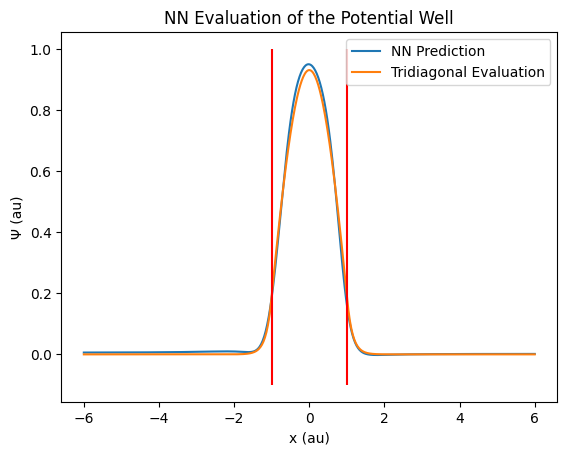

np.float64(0.00016063281471660377)

In [ ]:
x_test = np.linspace(minval, maxval, 601)
y_pred = model.predict(x_test)

V_d = np.where(np.abs(x_test) <= l, 0.0, v0)

dx = x_test[1] - x_test[0]

main_diag = 2.0 / dx**2 + V_d[1:-1]
off_diag = -1.0 / dx**2 * np.ones(601 - 3)

eigenvalues, eigenvectors = eigh_tridiagonal(main_diag, off_diag)

E0 = eigenvalues[0]
psi0 = eigenvectors[:, 0]

psi0 = psi0 / np.sqrt(np.trapz(psi0**2, x_test[1:-1]))

psi_full = np.zeros(601)
psi_full[1:-1] = psi0

y_true = psi_full

plt.plot(x_test, y_pred)

plt.plot(x_test, y_true)
plt.title('NN Evaluation of the Potential Well')
plt.legend(['NN Prediction', 'Tridiagonal Evaluation'])
plt.xlabel("x (au)")
plt.ylabel("Ψ (au)")
plt.vlines([-l, l], -0.1, 1, "r")
plt.show()

val_error = 0

for i in range(len(y_pred)):

  val_error += (y_pred[i] - y_true[i])**2

test_error = val_error/len(y_pred)
test_error = test_error[0]

test_error

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


/tmp/ipython-input-8-1538247240.py:16: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  psi0 = psi0 / np.sqrt(np.trapz(psi0**2, x_test[1:-1]))


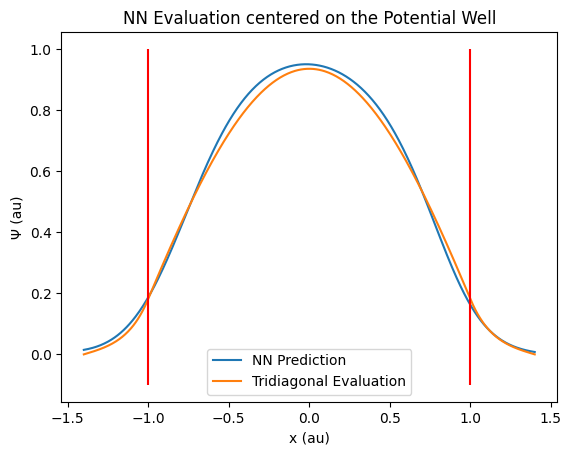

np.float64(0.0005043105130560427)

In [ ]:
x_test = np.linspace(-1.4, 1.4, 601)
y_pred = model.predict(x_test)

V_d = np.where(np.abs(x_test) <= l, 0.0, v0)

dx = x_test[1] - x_test[0]

main_diag = 2.0 / dx**2 + V_d[1:-1]
off_diag = -1.0 / dx**2 * np.ones(601 - 3)

eigenvalues, eigenvectors = eigh_tridiagonal(main_diag, off_diag)

E0 = eigenvalues[0]
psi0 = eigenvectors[:, 0]

psi0 = psi0 / np.sqrt(np.trapz(psi0**2, x_test[1:-1]))

psi_full = np.zeros(601)
psi_full[1:-1] = psi0

y_true = psi_full



plt.plot(x_test, y_pred)
plt.plot(x_test, y_true)

plt.title('NN Evaluation centered on the Potential Well')
plt.legend(['NN Prediction', 'Tridiagonal Evaluation'])
plt.xlabel("x (au)")
plt.ylabel("Ψ (au)")
plt.vlines([-l, l], -0.1, 1, "r")
plt.show()

val_error = 0

for i in range(len(y_pred)):

  val_error += (y_pred[i] - y_true[i])**2

test_error = val_error/len(y_pred)
test_error = test_error[0]

test_error

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 8)              │            16 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 6)              │            24 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │             7 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74 (296.00 B)

 Trainable params: 74 (296.00 B)

 Non-trainable params: 0 (0.00 B)

1.9451063716842611
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Montecarlo: 1	 Final Epoch = 1564	 Final MSE Loss = 7.42836928111501e-05
Test MSE Loss = 0.0001311108387745055


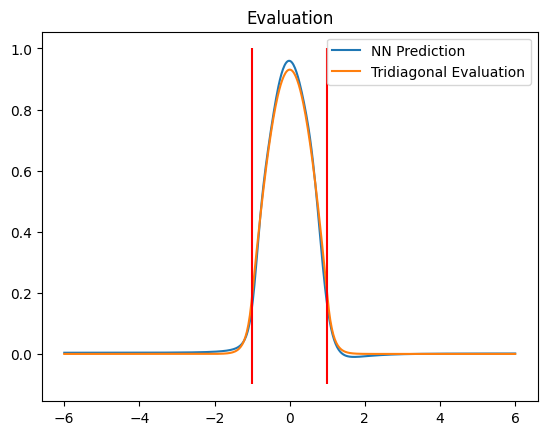

1.9451063716842611
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
Montecarlo: 2	 Final Epoch = 2000	 Final MSE Loss = 0.00013409339589998126
Test MSE Loss = 0.00014752910114820445
1.9451063716842611
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Montecarlo: 3	 Final Epoch = 696	 Final MSE Loss = 5.937018431723118e-05
Test MSE Loss = 0.00012967945178018366
1.9451063716842611
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Montecarlo: 4	 Final Epoch = 1939	 Final MSE Loss = 0.00010074534657178447
Test MSE Loss = 0.00016854766020497187
1.9451063716842611
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Montecarlo: 5	 Final Epoch = 1636	 Final MSE Loss = 6.998733442742378e-05
Test MSE Loss = 0.0001444300249141344
1.9451063716842611
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Montecarlo: 6	 Final Epoch = 490	 Final MSE Loss = 0.00018383834685664624
Test MSE Loss = 0.00023025638909869063
1.9451063716842611
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
Montecarlo: 7	 Final Epoch = 2000	 Final MSE Loss = 5.968661935185082e-05
Test MSE Loss

In [ ]:
num_domain = 64
l = 1
minval = -6*l
maxval = 6*l
v0 = 50

x = np.linspace(minval, maxval, num_domain)

epochs = 2000
learning_rate = 0.02

n_montecarlo = 50

final_epoch_arr = np.zeros(n_montecarlo)
final_train_error_arr = np.zeros(n_montecarlo)
test_error_arr = np.zeros(n_montecarlo)

def nn_pend(j, epochs, learning_rate, x):

  n_inputs = 1
  n_outputs = 1
  activation = 'tanh'

  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Input((n_inputs,)))
  model.add(tf.keras.layers.Dense(units=8, activation=activation))
  model.add(tf.keras.layers.Dense(units=3, activation=activation))
  model.add(tf.keras.layers.Dense(units=6, activation=activation))
  model.add(tf.keras.layers.Dense(units=n_outputs))

  if j == 0:

    model.summary()

  early_stop = EarlyStopping(
      monitor='loss',
      patience=8,
      restore_best_weights=True
  )

  model.compile(optimizer="adam", loss="mse")

  V_d = np.where(np.abs(x) <= l, 0.0, v0)

  dx = x[1] - x[0]

  main_diag = 2.0 / dx**2 + V_d[1:-1]
  off_diag = -1.0 / dx**2 * np.ones(num_domain - 3)

  eigenvalues, eigenvectors = eigh_tridiagonal(main_diag, off_diag)

  E0 = eigenvalues[0]
  psi0 = eigenvectors[:, 0]

  print(E0)

  psi0 = psi0 / np.sqrt(scipy.integrate.simpson(psi0**2, x[1:-1]))

  psi_full = np.zeros(num_domain)
  psi_full[1:-1] = psi0

  y_true = psi_full

  history = model.fit(x, y_true, epochs=epochs, batch_size=1, callbacks=[early_stop], verbose=0)
  final_epoch = len(history.history['loss'])
  final_train_error = history.history['loss'][-1]

  x_test = np.linspace(minval, maxval, 601)
  y_pred = model.predict(x_test)

  V_d = np.where(np.abs(x_test) <= l, 0.0, v0)

  dx = x_test[1] - x_test[0]

  main_diag = 2.0 / dx**2 + V_d[1:-1]
  off_diag = -1.0 / dx**2 * np.ones(601 - 3)

  eigenvalues, eigenvectors = eigh_tridiagonal(main_diag, off_diag)

  E0 = eigenvalues[0]
  psi0 = eigenvectors[:, 0]

  psi0 = psi0 / np.sqrt(scipy.integrate.simpson(psi0**2, x_test[1:-1]))

  psi_full = np.zeros(601)
  psi_full[1:-1] = psi0

  y_true = psi_full


  val_error = 0

  for i in range(len(y_pred)):

    val_error += (y_pred[i] - y_true[i])**2

  test_error = val_error/len(y_pred)
  test_error = test_error[0]

  final_epoch_arr[j] = final_epoch
  final_train_error_arr[j] = final_train_error
  test_error_arr[j] = test_error

  print('Montecarlo: {}\t Final Epoch = {}\t Final MSE Loss = {}'.format(j+1, final_epoch, final_train_error), flush=True)
  print('Test MSE Loss = {}'.format(test_error), flush=True)

  if j == 0:

    plt.plot(x_test, y_pred)
    plt.plot(x_test, y_true)

    plt.title('Evaluation')
    plt.legend(['NN Prediction', 'Tridiagonal Evaluation'])
    plt.vlines([-l, l], -0.1, 1, "r")
    plt.show()

for j in range(n_montecarlo):

  nn_pend(j, epochs, learning_rate, x)

final_epoch_mean = final_epoch_arr.mean()
final_epoch_var = final_epoch_arr.var()
final_train_error_mean = final_train_error_arr.mean()
final_train_error_var = final_train_error_arr.var()
test_error_mean = test_error_arr.mean()
test_error_var = test_error_arr.var()

print(f"""
Mean final epoch: {final_epoch_mean}                Final Epoch Variance: {final_epoch_var}
Mean final error: {final_train_error_mean}             Final error Variance: {final_train_error_var}
Mean testing error: {test_error_mean}         Testing error Variance: {test_error_var}
""")